Okay. Can neural nets learn polynomials?

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim 
from torch.utils.data import TensorDataset, random_split
import matplotlib.pyplot as plt
from typing import Callable

In [2]:
torch.manual_seed(0)
# Prepare dataset
# Generates polynomial data 
def polynomial_data_gen(eq: Callable[[torch.Tensor], torch.Tensor], n: int = 2, x_range: list = [0, 1], noise: float = 0):
    assert noise >= 0
    x = torch.linspace(x_range[0], x_range[1], n) 
    offset = torch.rand(n) * torch.randint(-noise, noise, (n,)) if noise else torch.zeros(n)
    y = eq(x) + offset
    return x, y

In [3]:
class CustomLinearNet(nn.Module):
    def __init__(self, _in_s: int, _out_s: int, layer_conf: list):
        super().__init__()
        self._layers = nn.ModuleList(
            [getattr(torch.nn, layer_type)(**kwargs) for layer_type, kwargs in layer_conf]
        )
    
    def forward(self, x):
        for layer in self._layers:
            x = layer(x)
        return x 

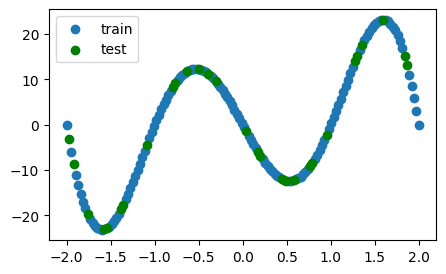

In [4]:
eq = lambda x: (x - 3)*(x - 2)*(x - 1)*(x)*(x + 1)*(x + 2)*(x + 3) 
X , Y = polynomial_data_gen(eq, n = 150, x_range = [-2, 2], noise= 0)
r = 0.8
train_size = int(len(X) * r) 
test_size = len(X) - train_size
train, test =  random_split(TensorDataset(X, Y), [train_size, test_size])
x_train, y_train = train[:]
x_test, y_test= test[:]

fig, ax = plt.subplots(figsize=(5,3))
ax.scatter(x_train, y_train, label='train')
ax.scatter(x_test, y_test, color='green', label='test')
ax.legend()

In [5]:
x_train_reshaped = x_train.reshape(-1, 1)
y_train_reshaped = y_train.reshape(-1, 1)

In [6]:
model = CustomLinearNet(1,1, 
                        [ ('Linear', {'in_features': 1, 'out_features': 40}), 
                            ('ReLU', {}),
                            ('Linear', {'in_features': 40, 'out_features': 30}), 
                            ('ReLU', {}),
                            ('Linear', {'in_features': 30, 'out_features': 10}), 
                            ('ReLU', {}),
                            ('Linear', {'in_features': 10, 'out_features': 10}), 
                            ('ReLU', {}),
                            ('Linear', {'in_features': 10, 'out_features': 1}), 
                        ]
                       )
print(f"Model: \n{model}")
EPOCH = 50 
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)

print("Training loop:")
# Training loop
for epoch in range(EPOCH):
    # Forward pass
    ypred = model.forward(x_train_reshaped)
    
    # Zero grad
    optimizer.zero_grad()
    
    # Backward pass
    loss = criterion(ypred, y_train_reshaped)
    loss.backward()
    
    # Update
    optimizer.step()
    
    print(f"epoch {epoch}, Loss: {loss.item()}")

Model: 
CustomLinearNet(
  (_layers): ModuleList(
    (0): Linear(in_features=1, out_features=25, bias=True)
    (1): ReLU()
    (2): Linear(in_features=25, out_features=20, bias=True)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=10, bias=True)
    (5): ReLU()
    (6): Linear(in_features=10, out_features=6, bias=True)
    (7): ReLU()
    (8): Linear(in_features=6, out_features=1, bias=True)
  )
)
Training loop:
epoch 0, Loss: 168.42742919921875
epoch 1, Loss: 167.77122497558594
epoch 2, Loss: 162.99383544921875
epoch 3, Loss: 150.90792846679688
epoch 4, Loss: 126.92701721191406
epoch 5, Loss: 118.12825775146484
epoch 6, Loss: 133.9815673828125
epoch 7, Loss: 96.23130798339844
epoch 8, Loss: 97.76387786865234
epoch 9, Loss: 102.65702819824219
epoch 10, Loss: 98.23519134521484
epoch 11, Loss: 94.72711944580078
epoch 12, Loss: 86.53961944580078
epoch 13, Loss: 80.6812973022461
epoch 14, Loss: 81.15006256103516
epoch 15, Loss: 82.64347076416016
epoch 16, Loss: 82.2186813354

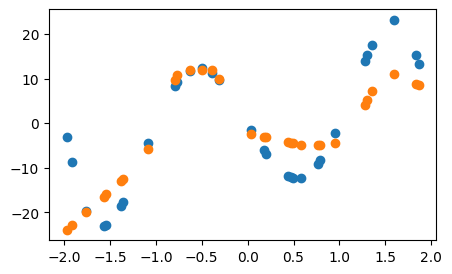

In [7]:
x_test_reshaped = x_test.reshape(-1, 1)
y_test_reshaped = y_test.reshape(-1, 1)
ypred = model.forward(x_test_reshaped)

fig, ax = plt.subplots(figsize=(5,3))
ax.scatter(x_test, y_test, label = 'test')

ax.scatter(x_test_reshaped.detach().numpy(), ypred.detach().numpy(), label = 'predicted')

https://theory.stanford.edu/~valiant/papers/andoni14.pdf